### Imports

In [39]:
!! pip install pymixbox pandas matplotlib seaborn

['Requirement already satisfied: pymixbox in c:\\python310\\lib\\site-packages (2.0.0)',
 'Requirement already satisfied: pandas in c:\\python310\\lib\\site-packages (2.3.3)',
 'Requirement already satisfied: matplotlib in c:\\python310\\lib\\site-packages (3.10.7)',
 'Requirement already satisfied: seaborn in c:\\python310\\lib\\site-packages (0.13.2)',
 'Requirement already satisfied: pytz>=2020.1 in c:\\python310\\lib\\site-packages (from pandas) (2025.2)',
 'Requirement already satisfied: tzdata>=2022.7 in c:\\python310\\lib\\site-packages (from pandas) (2025.2)',
 'Requirement already satisfied: python-dateutil>=2.8.2 in c:\\users\\safii\\appdata\\roaming\\python\\python310\\site-packages (from pandas) (2.9.0.post0)',
 'Requirement already satisfied: numpy>=1.22.4 in c:\\python310\\lib\\site-packages (from pandas) (2.2.6)',
 'Requirement already satisfied: cycler>=0.10 in c:\\python310\\lib\\site-packages (from matplotlib) (0.12.1)',
 'Requirement already satisfied: packaging>=20.

In [40]:
import pandas as pd
import math
from typing import Callable
import mixbox
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import to_hex
import json
import os
import matplotlib.patches as patches
from pathlib import Path
import numpy as np

### Error Definitions

Delta E	Perception

|  Value  | Meaning |
|---------|---|
|  <= 1.0 | Not perceptible by human eyes.  |
|  1 - 2  | Perceptible through close observation.  |
| 2 - 10  | Perceptible at a glance. |
| 11 - 49 | Colors are more similar than opposite  |
| 100     | Colors are exact opposite 

In [41]:
def deltaE76(color1: list[float], color2: list[float]) -> float:
    dl = color1[0] - color2[0]
    da = color1[1] - color2[1]
    db = color1[2] - color2[2]

    return math.sqrt(dl*dl + da*da + db*db)

In [42]:
def rmsErrorForDim(color1: list[float], color2: list[float], dim: str) -> float:
    labDim = 0 if dim == "l" else 1 if dim == "a" else 2
    return math.sqrt((color1[labDim] - color2[labDim])**2)

In [43]:
def calculateAverageError(errorFunction: Callable[[list[float], list[float]], float], dataset, field1: str, field2: str) -> float:
    error_values = []
    for i in range(len(dataset)):
        targetLab = [float(x) for x in dataset[field1][i].split(";")]
        resultLab = [float(x) for x in dataset[field2][i].split(";")]
        error_values.append(errorFunction(targetLab, resultLab))
    return sum(error_values) / (len(error_values) if len(error_values) else 1)

### Color Mixing with Mixbox

In [44]:
def mix_colors_mixbox(weights: list[float], palette: list[tuple[int, int, int]]) -> tuple[int, int, int]:
    """
    ColorMixer Implementation: Realistic pigment mixing using Mixbox library.
    
    Mixbox provides physically-accurate color mixing that simulates real paint behavior,
    including subtractive color mixing effects.
    
    This implementation uses iterative pairwise mixing for multiple colors.
    
    Args:
        weights: List of weights (0.0 to 1.0) for each color in the palette.
        palette: List of RGB colors as tuples (R, G, B) where each component is 0-255.
    
    Returns:
        Mixed RGB color as tuple (R, G, B) where each component is 0-255.
    """
    if len(weights) != len(palette):
        raise ValueError("Weights size must match palette size")
    
    if not palette:
        # Return neutral gray for empty palette
        return (128, 128, 128)
    
    # Create list of colors with their weights, filtering negligible contributions
    weighted_colors = [
        (palette[i], weights[i])
        for i in range(len(weights))
        if weights[i] > 0.01  # Filter negligible contributions
    ]
    
    # Sort by weight descending
    weighted_colors.sort(key=lambda x: x[1], reverse=True)
    
    if not weighted_colors:
        return (128, 128, 128)
    
    if len(weighted_colors) == 1:
        # Single color - return it directly
        return weighted_colors[0][0]
    
    # Iteratively mix colors using Mixbox
    mixed_color = weighted_colors[0][0]
    total_weight = weighted_colors[0][1]
    
    for i in range(1, len(weighted_colors)):
        next_color = weighted_colors[i][0]
        next_weight = weighted_colors[i][1]
        
        # Calculate mixing ratio
        t = next_weight / (total_weight + next_weight)
        
        # Use Mixbox for realistic pigment mixing
        mixed_color = mixbox.lerp(mixed_color, next_color, t)
        total_weight += next_weight
    
    return mixed_color

## Comaring different optimization strategies

In [45]:
def count_false_weights(result_w, target_w, threshold, similarity_groups=None):
    # Simple non-domain logic
    if similarity_groups is None:
        return sum(abs(r - t) > threshold for r, t in zip(result_w, target_w))

    # Domain-aware logic
    COLOR_TO_GROUP = {
        idx: g
        for g, indices in similarity_groups.items()
        for idx in indices
    }

    false_count = 0
    for i, (r, t) in enumerate(zip(result_w, target_w)):
        if abs(r - t) <= threshold:
            continue

        group = COLOR_TO_GROUP[i]
        group_indices = similarity_groups[group]

        target_sum = sum(target_w[j] for j in group_indices)
        result_sum = sum(result_w[j] for j in group_indices)

        if abs(target_sum - result_sum) <= threshold:
            continue

        false_count += 1

    return false_count


In [46]:
def rmse_false_weights(result_w, target_w, threshold, similarity_groups=None):
    if similarity_groups is None:
        diffs = [(r - t)**2 for r, t in zip(result_w, target_w) if abs(r - t) > threshold]
        return math.sqrt(sum(diffs) / len(diffs)) if diffs else 0.0

    COLOR_TO_GROUP = {
        idx: g
        for g, indices in similarity_groups.items()
        for idx in indices
    }

    sq_errors = []

    for i, (r, t) in enumerate(zip(result_w, target_w)):
        diff = r - t
        if abs(diff) <= threshold:
            continue

        group = COLOR_TO_GROUP[i]
        group_indices = similarity_groups[group]

        target_sum = sum(target_w[j] for j in group_indices)
        result_sum = sum(result_w[j] for j in group_indices)

        if abs(target_sum - result_sum) <= threshold:
            continue

        sq_errors.append(diff * diff)

    return math.sqrt(sum(sq_errors) / len(sq_errors)) if sq_errors else 0.0


In [47]:
def parse_lab_string(s):
    return list(map(float, s.split(";")))

## Comparing different optimization parameters for a given strategy

In [48]:
def analyze_optimizer(
    dataset_folder,
    common_columns,
    threshold=0.1,
    similarity_groups=None,
    weight_result_col="resultWeights",
    weight_target_col="targetWeights"
):

    csv_files = [f for f in os.listdir(dataset_folder) if f.endswith(".csv")]
    results = []

    for csv_file in csv_files:
        path = os.path.join(dataset_folder, csv_file)
        dataset = pd.read_csv(path)

        # --- Parse weights ---
        dataset[weight_result_col] = dataset[weight_result_col].str.split(";").apply(lambda x: list(map(float, x)))
        dataset[weight_target_col] = dataset[weight_target_col].str.split(";").apply(lambda x: list(map(float, x)))

        # --- Compute domain-aware or simple weight errors ---
        dataset["NumFalseWeights"] = dataset.apply(
            lambda row: count_false_weights(
                row[weight_result_col], row[weight_target_col], threshold, similarity_groups
            ),
            axis=1
        )

        dataset["RMSEFalseWeights"] = dataset.apply(
            lambda row: rmse_false_weights(
                row[weight_result_col], row[weight_target_col], threshold, similarity_groups
            ),
            axis=1
        )

        # --- ΔE metrics ---
        avg_error_result = calculateAverageError(deltaE76, dataset, "targetLab", "resultLab")
        avg_error_initial = calculateAverageError(deltaE76, dataset, "targetLab", "initialLab")

        # --- Convergence ---
        dataset["converged"] = dataset["converged"].astype(str).str.lower() == "true"
        conv_rate = dataset["converged"].mean()

        # --- Common statistics ---
        runtime_mean = dataset["runtimeMs"].mean()

        # --- Detect optimizer-specific parameters automatically ---
        param_columns = dataset.columns.difference(common_columns)
        optimizer_params = {col: dataset[col].iloc[0] for col in param_columns}

        mean_num_eval = dataset["numberOfEvaluations"].mean()

        # --- Assemble row ---
        row = {
            "File": csv_file,
            "Average Result Error": avg_error_result,
            "Average Initial Error": avg_error_initial,
            "Runtime (ms)": runtime_mean,
            "Convergence Rate": conv_rate,
            "Number of Evaluations": mean_num_eval
        }

        row.update(optimizer_params)
        results.append(row)

    return pd.DataFrame(results)


In [49]:
def analyse(db_folder):

    SIMILAR_GROUPS = {
        "yellow": [0, 2, 6],
        "red":    [1, 4],
        "blue":   [3, 8, 10],
        "earth":  [5],
        "white":  [7],
        "black":  [9],
    }

    COMMON_COLUMNS = [
        "targetLab",
        "resultLab",
        "initialLab",
        "targetWeights",
        "resultWeights",
        "initialWeights",
        "numberOfEvaluations",
        "mixingErrorName",
        "penalties",
        "normalizer",
        "initialGuessType",
        "runtimeMs",
        "converged",
    ]


    results = analyze_optimizer(
        dataset_folder=db_folder,
        common_columns=COMMON_COLUMNS,
        threshold=0.1,
        similarity_groups=SIMILAR_GROUPS,
    )

    return results


In [50]:
COMPARISON_COLUMNS = [
        'optimizerName',
        'Average Result Error',
        'Average Initial Error',
        'Runtime (ms)',
        'Convergence Rate',
        'NumFalseWeights',
        'RMSEFalseWeights',
        "Number of Evaluations"
    ]

In [51]:
db_folder = "C:\\Users\\safii\\CI_presentation\\datasets\\"

results = analyse(db_folder)
results[COMPARISON_COLUMNS]


,optimizerName,Average Result Error,Average Initial Error,Runtime (ms),Convergence Rate,NumFalseWeights,RMSEFalseWeights,Number of Evaluations
0,BOBYQA,43.671001,56.685908,16.85,1.0,11,0.314357,87.0
1,CMA-ES,5.164211,56.685908,123.60,0.0,3,0.570986,9410.5
2,Nelder-Mead,26.004887,56.685908,0.10,1.0,10,3.384677,194.2
3,NSGAII,10.189884,56.685908,103965.85,1.0,3,0.874155,50000.0
4,Powell,26.004887,56.685908,1.25,1.0,10,3.384677,194.2
5,SMSEMOA,12.941743,56.685908,34950.85,1.0,3,0.476050,50000.0


C:\Users\safii\AppData\Local\Temp\ipykernel_2924\4272843984.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


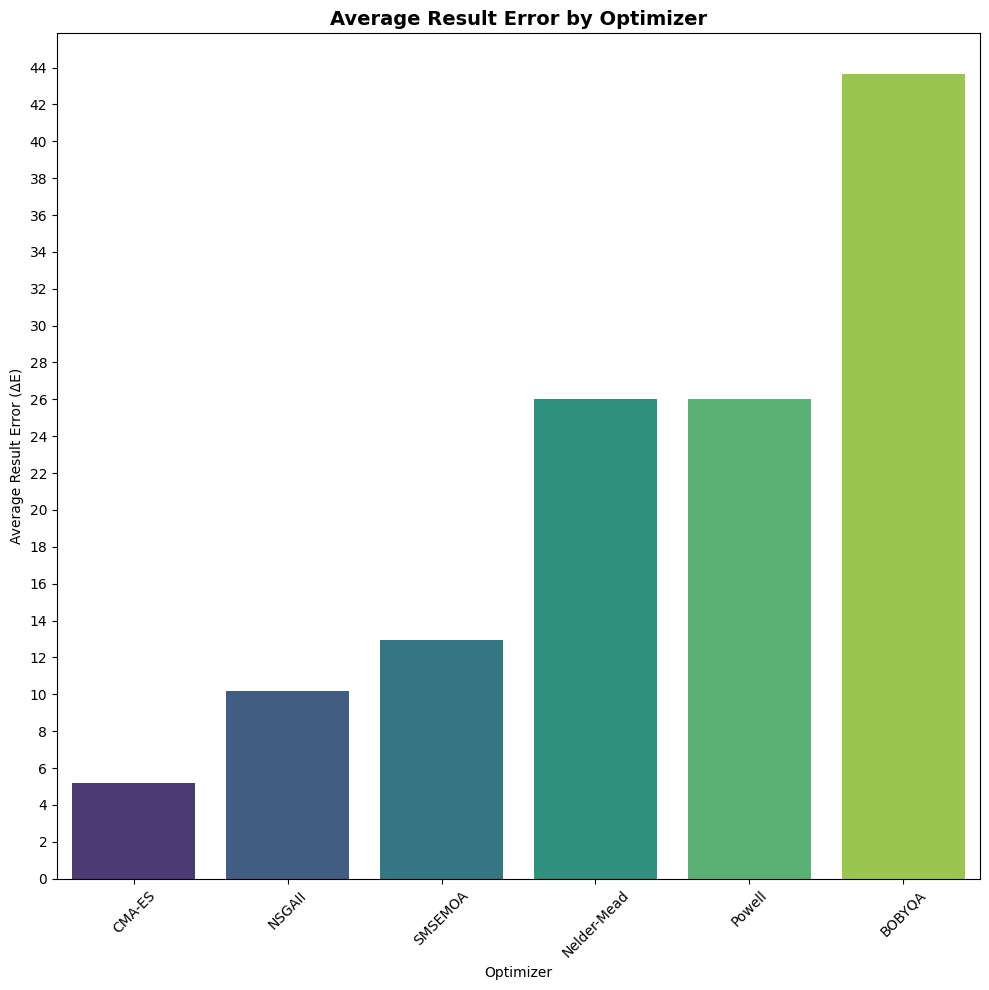

In [52]:
import numpy as np

df_plot = results.sort_values("Average Result Error")

plt.figure(figsize=(10, 10))
sns.barplot(
    data=df_plot,
    x="optimizerName",
    y="Average Result Error",
    palette="viridis"
)

plt.title("Average Result Error by Optimizer", fontsize=14, fontweight="bold")
plt.ylabel("Average Result Error (ΔE)")
plt.xlabel("Optimizer")
plt.xticks(rotation=45)
plt.yticks(np.arange(0, df_plot["Average Result Error"].max() + 2, 2))
plt.tight_layout()
plt.show()

In [53]:
def create_box_plot(db_folder):
    csv_files = [f for f in os.listdir(db_folder) if f.endswith(".csv")]

    sample_error_results = []
    for file in csv_files:
        file_dir = db_folder + file
        dataset = pd.read_csv(file_dir)
        dataset["sample_error"] = dataset.apply(
                lambda row: deltaE76(
                    parse_lab_string(row["targetLab"]), 
                    parse_lab_string(row["resultLab"])
                    ),
                axis=1
            )
        sample_error_results.append(dataset[["optimizerName", "sample_error"]])
    sample_error_results = pd.concat(sample_error_results, ignore_index=True)
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        data=sample_error_results,
        x="optimizerName",
        y="sample_error",
        palette="viridis"
    )

    plt.title("Error Distribution (Boxplot) per Optimizer", fontsize=14)
    plt.xlabel("Optimizer")
    plt.ylabel("ΔE Error")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

C:\Users\safii\AppData\Local\Temp\ipykernel_2924\4005373813.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


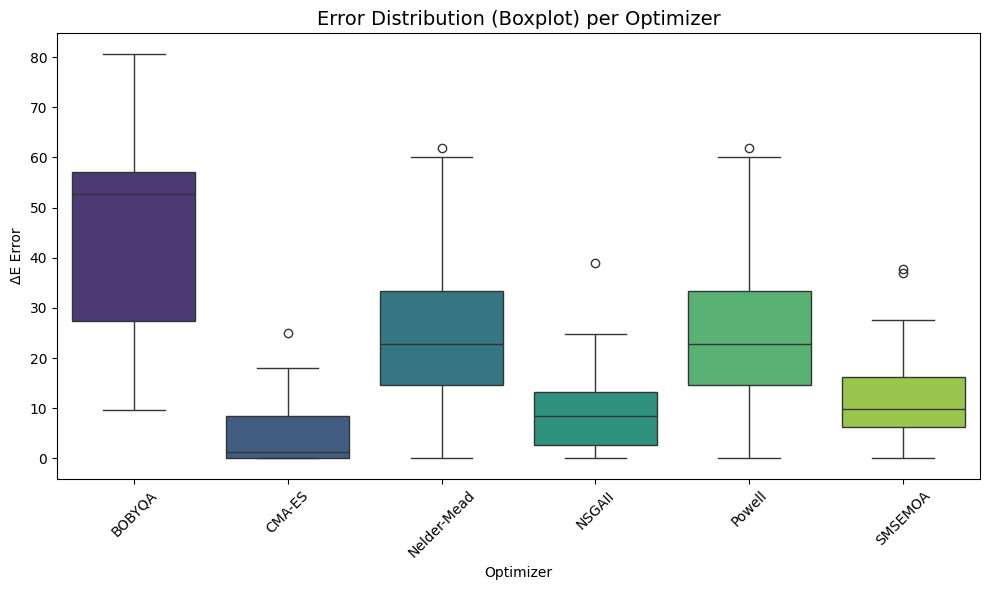

In [55]:
create_box_plot(db_folder)

## Performance Overview
- CMA-ES: lowest error for reasonable time considering number of evaluations and lowest weight error rate.
- NSGAII: second lowest error but way too slow, number of evaluations possibly wrong
- SMSEMOA: same as NSGAII
- Nelder-Mead	and Powell: super fast but way less accurate
- BOBYQA: worst by performance

| Optimizer       | Error Rank | Speed Rank | Weight Quality Rank | Convergence Rank | Overall Score |
| --------------- | ---------- | ---------- | ------------------- | ---------------- | ------------- |
| **CMA-ES**      | 🥇 1       | 4          | 1                   | 6                | **12**        |
| **NSGA-II**     | 2          | 6          | 2                   | 1                | **11**        |
| **SMSEMOA**     | 3          | 5          | 3                   | 1                | **12**        |
| **Nelder-Mead** | 4          | 🥇 1       | 5                   | 1                | **11**        |
| **Powell**      | 4          | 2          | 5                   | 1                | **12**        |
| **BOBYQA**      | 6          | 3          | 6                   | 1                | **16**        |


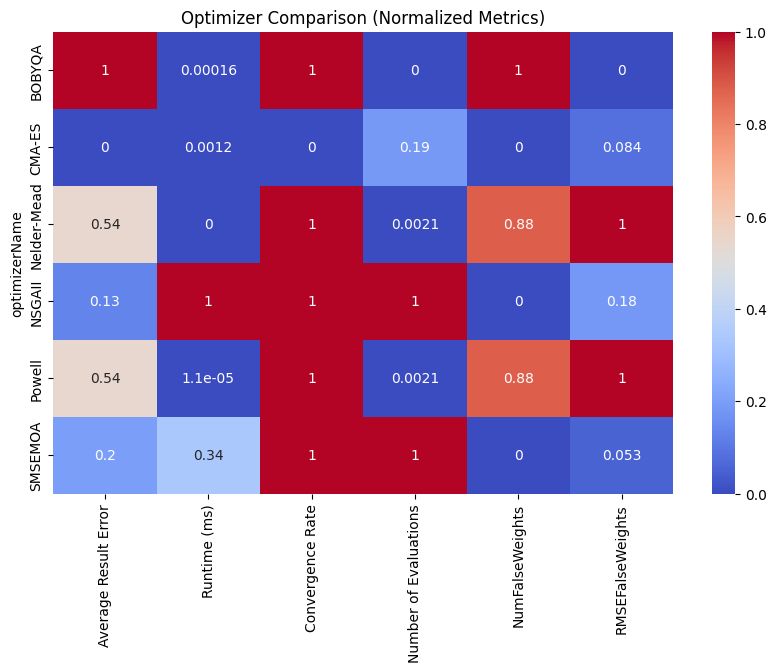

In [56]:
UNUSED_COLUMNS = [
    "Average Initial Error",
    "numberOfInterpolationPoints",
    "checkFeasibleCount",
    "diagonalOnly",
    "populationMultiplier",
    "sigma",
    "stopFitness",
    "absoluteThreshold",
    "relativeThreshold",
    "stepSize",
    "pmRate",
    "pmDistributionIndex",
    "populationSize",
    "sbxDistributionIndex",
    "sbxRate",
    "maxEvaluations"
]

db_folder = "C:\\Users\\safii\\CI_presentation\\datasets\\"

results = analyse(db_folder)

df = results.drop(UNUSED_COLUMNS, axis=1)

df = df.set_index("optimizerName")

# 2. Select only numeric columns
numeric_df = df.select_dtypes(include="number")

# 3. Normalize numeric columns
df_norm = (numeric_df - numeric_df.min()) / (numeric_df.max() - numeric_df.min())

# 4. Plot heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df_norm, annot=True, cmap="coolwarm")
plt.title("Optimizer Comparison (Normalized Metrics)")
plt.show()


## Hyperparameter Optimization for CMA-ES

In [57]:

def find_best_parameters(dir_path: str, common_columns: list[str]):
    results = []

    for file in os.listdir(dir_path):
        if not file.endswith(".csv"):
            continue

        full_path = os.path.join(dir_path, file)
        dataset = pd.read_csv(full_path, sep=",")

        avg_error_result = calculateAverageError(deltaE76, dataset, "targetLab", "resultLab")

        param_columns = dataset.columns.difference(common_columns)
        params = {col: dataset[col].iloc[0] for col in param_columns}

        params["avg_error_result"] = avg_error_result
        params["file"] = file

        results.append(params)

    # Convert list of dicts → DataFrame
    results_df = pd.DataFrame(results)

    # --- Find best parameters ---
    best = results_df.loc[results_df["avg_error_result"].idxmin()]

    return results_df, best

### Nelder Mead (> 22 min)

In [58]:
db_folder = "C:\\Users\\safii\\CI_presentation\\datasets\\CMA-ES-Hyperparameter-Runs-Nelder-Mead\\"

COMMON_COLUMNS = [
    "targetLab",
    "resultLab",
    "initialLab",
    "targetWeights",
    "resultWeights",
    "initialWeights",
    "numberOfEvaluations",
    "mixingErrorName",
    "penalties",
    "normalizer",
    "initialGuessType",
    "runtimeMs",
    "converged",
]

find_best_parameters(db_folder, COMMON_COLUMNS)[1]


checkFeasibleCount                         11
diagonalOnly                               11
optimizerName                          CMA-ES
populationMultiplier                       13
sigma                                0.389002
stopFitness                          0.001234
avg_error_result                     3.982888
file                    run-1765058286487.csv
Name: 138, dtype: object

### CMA-ES (> 16) with Uniform weights

In [59]:
db_folder = "C:\\Users\\safii\\CI_presentation\\datasets\\CMA-ES-Hyperparameter-Runs-CMA-ES\\"

COMMON_COLUMNS = [
    "targetLab",
    "resultLab",
    "initialLab",
    "targetWeights",
    "resultWeights",
    "initialWeights",
    "numberOfEvaluations",
    "mixingErrorName",
    "penalties",
    "normalizer",
    "initialGuessType",
    "runtimeMs",
    "converged",
]

find_best_parameters(db_folder, COMMON_COLUMNS)[1]


checkFeasibleCount                         11
diagonalOnly                               12
optimizerName                          CMA-ES
populationMultiplier                       12
sigma                                0.067537
stopFitness                             0.001
avg_error_result                     2.036092
file                    run-1765061237168.csv
Name: 266, dtype: object

### CMA-ES (> 14) with Similar weights

In [60]:
db_folder = "C:\\Users\\safii\\CI_presentation\\datasets\\hyperparam_runs\\cmaes"

COMMON_COLUMNS = [
    "targetLab",
    "resultLab",
    "initialLab",
    "targetWeights",
    "resultWeights",
    "initialWeights",
    "numberOfEvaluations",
    "mixingErrorName",
    "penalties",
    "normalizer",
    "initialGuessType",
    "runtimeMs",
    "converged",
]

find_best_parameters(db_folder, COMMON_COLUMNS)[1]


checkFeasibleCount                          9
diagonalOnly                               12
optimizerName                          CMA-ES
populationMultiplier                       12
sigma                                0.204046
stopFitness                          0.002099
avg_error_result                     2.600779
file                    run-1765119130304.csv
Name: 253, dtype: object

### Overall best parameters for CMA-ES
|  parameter | value  |
|---|---|
| checkFeasibleCount  |  11 |
| diagonalOnly  | 12  |
|  populationMultiplier |  12 |
| sigma  | 0.067537  |
| stopFitness  | 0.001  |
|  avg_error_result | 2.036092  |

In [61]:
db_folder = "C:\\Users\\safii\\CI_presentation\\datasets\\CMA-ES-Optimized\\"

SIMILAR_GROUPS = {
    "yellow": [0, 2, 6],
    "red":    [1, 4],
    "blue":   [3, 8, 10],
    "earth":  [5],
    "white":  [7],
    "black":  [9],
}

COMMON_COLUMNS = [
    "targetLab",
    "resultLab",
    "initialLab",
    "targetWeights",
    "resultWeights",
    "initialWeights",
    "numberOfEvaluations",
    "mixingErrorName",
    "penalties",
    "normalizer",
    "initialGuessType",
    "runtimeMs",
    "converged",
]

COMPARISON_COLUMNS = [
    "File",
    'optimizerName',
    'Average Result Error',
    'Average Initial Error',
    'Runtime (ms)',
    'Convergence Rate',
    'NumFalseWeights',
    'RMSEFalseWeights',
    "Number of Evaluations"
]


results = analyze_optimizer(
    dataset_folder=db_folder,
    common_columns=COMMON_COLUMNS,
    threshold=0.1,
    similarity_groups=SIMILAR_GROUPS,
)
results[COMPARISON_COLUMNS]


,File,optimizerName,Average Result Error,Average Initial Error,Runtime (ms),Convergence Rate,NumFalseWeights,RMSEFalseWeights,Number of Evaluations
0,cmaes-results-1.csv,CMA-ES,17.599376,25.771060,304.30,0.0,0,0.000000,7521.72
1,cmaes-results-2.csv,CMA-ES,2.666649,54.065407,129.48,0.0,4,0.418352,9681.96
2,cmaes-results-similar-2.csv,CMA-ES,4.662990,54.065407,146.72,0.0,4,0.388330,9098.92
3,cmaes-results-similar.csv,CMA-ES,4.561038,54.065407,131.52,0.0,0,0.000000,9556.52
4,cmaes-results.csv,CMA-ES,9.848800,52.317963,175.88,0.0,0,0.000000,9481.80


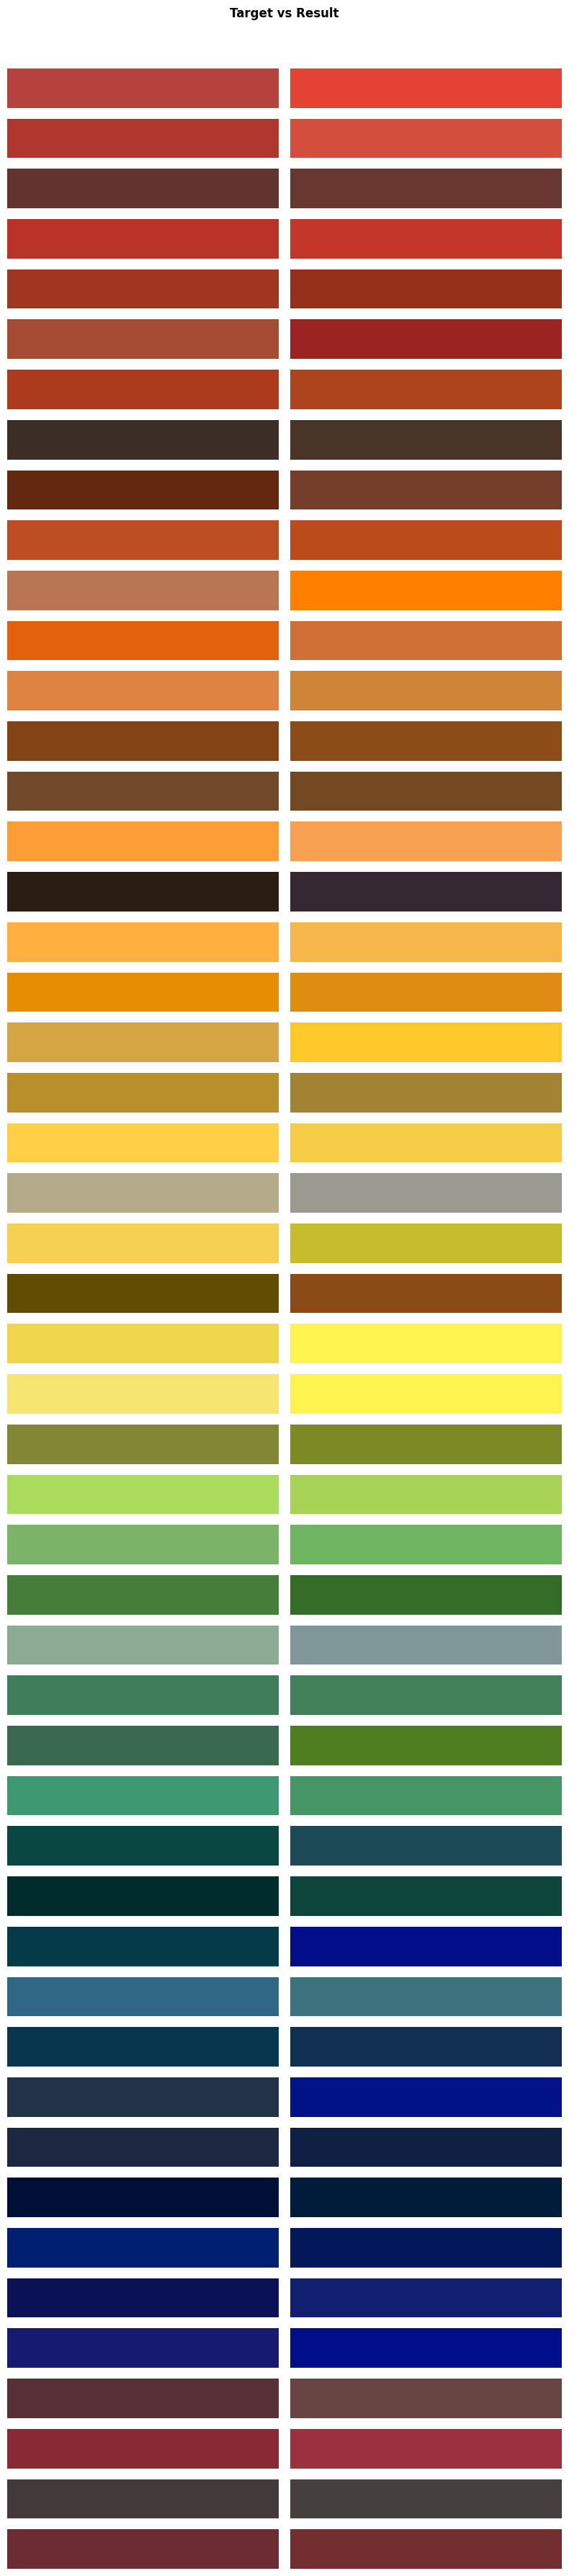

In [62]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import colorsys

# --------------------------------------
# Helper: parse LAB triplet ("L;A;B")
# --------------------------------------
def parse_lab(lab_string):
    L, a, b = map(float, lab_string.split(";"))
    return pd.Series({"L": L, "A": a, "B": b})

# --------------------------------------
# Helper: format RGB → hex
# --------------------------------------
def rgb_to_hex(rgb):
    return "#{:02x}{:02x}{:02x}".format(*rgb)


def luminance(rgb):
    r, g, b = rgb
    return 0.2126 * r + 0.7152 * g + 0.0722 * b

def rgb_to_hsv_hue(rgb):
    r, g, b = [x / 255.0 for x in rgb]
    h, s, v = colorsys.rgb_to_hsv(r, g, b)
    return h  # hue only

# --------------------------------------
# Load palette (list of RGB tuples)
# --------------------------------------
with open("C:\\Users\\safii\\CI_presentation\\palette.json", "r") as file:
    palette_data = json.load(file)

palette = [tuple(color["rgb"]) for color in palette_data]

# --------------------------------------
# Load dataset
# --------------------------------------
dataset = pd.read_csv("C:\\Users\\safii\\CI_presentation\\datasets\\CMA-ES-Optimized\\cmaes-results.csv")

dataset = dataset[["targetLab", "resultLab", "targetWeights", "resultWeights"]]

# --------------------------------------
# Parse LAB into numeric columns
# --------------------------------------
dataset[["L", "A", "B"]] = dataset["targetLab"].apply(parse_lab)

# --------------------------------------
# Parse weights into numeric lists
# --------------------------------------
dataset["targetWeights_parsed"] = dataset["targetWeights"].str.split(";").apply(lambda x: list(map(float, x)))
dataset["resultWeights_parsed"] = dataset["resultWeights"].str.split(";").apply(lambda x: list(map(float, x)))

# --------------------------------------
# Select and sort samples by LAB
# --------------------------------------
num_samples = 50

sampled = dataset.sample(n=min(num_samples, len(dataset)), random_state=42)
sampled["target_rgb_val"] = sampled["targetWeights_parsed"].apply(lambda w: mix_colors_mixbox(w, palette))
sampled["hue"] = sampled["target_rgb_val"].apply(rgb_to_hsv_hue)
sampled = sampled.sort_values("hue")

# --------------------------------------
# Mix target+result colors using mixbox
# --------------------------------------
results = []

for idx, row in sampled.iterrows():
    target_w = row["targetWeights_parsed"]
    result_w = row["resultWeights_parsed"]

    target_rgb = mix_colors_mixbox(target_w, palette)
    result_rgb = mix_colors_mixbox(result_w, palette)

    results.append({
        "row": idx,
        "target_rgb": target_rgb,
        "result_rgb": result_rgb,
        "target_hex": rgb_to_hex(target_rgb),
        "result_hex": rgb_to_hex(result_rgb)
    })

# --------------------------------------
# Visual Table (Target vs Result)
# --------------------------------------
fig, axes = plt.subplots(len(results), 2, figsize=(8, len(results) * 0.7))

for i, r in enumerate(results):
    # Target
    axes[i][0].add_patch(patches.Rectangle((0, 0), 1, 1, facecolor=r["target_hex"]))
    axes[i][0].axis("off")

    # Result
    axes[i][1].add_patch(patches.Rectangle((0, 0), 1, 1, facecolor=r["result_hex"]))
    axes[i][1].axis("off")

plt.tight_layout()
plt.suptitle("Target vs Result", y=1.02, fontsize=12, fontweight="bold")
plt.show()


In [63]:
db_folder = "C:\\Users\\safii\\CI_presentation\\datasets\\hyperparam_runs\\"

COMMON_COLUMNS = [
    "targetLab",
    "resultLab",
    "initialLab",
    "targetWeights",
    "resultWeights",
    "initialWeights",
    "numberOfEvaluations",
    "mixingErrorName",
    "penalties",
    "normalizer",
    "initialGuessType",
    "runtimeMs",
    "converged",
]

folders = os.listdir(db_folder)
best = []
for folder in folders:
    full_name = db_folder + folder
    if os.listdir(full_name):
        best.append(find_best_parameters(full_name, COMMON_COLUMNS)[1])

for best_params in best:
    print(best_params)


maxEvaluations                                  3546
numberOfInterpolationPoints                       36
optimizerName                                 BOBYQA
avg_error_result                           32.699735
file                           run-1765098665589.csv
Name: 2, dtype: object
checkFeasibleCount                          9
diagonalOnly                               12
optimizerName                          CMA-ES
populationMultiplier                       12
sigma                                0.204046
stopFitness                          0.002099
avg_error_result                     2.600779
file                    run-1765119130304.csv
Name: 253, dtype: object
absoluteThreshold                  0.00001
maxEvaluations                        2000
optimizerName                  Nelder-Mead
relativeThreshold                   0.0001
stepSize                              0.01
avg_error_result                 11.095312
file                 run-1765099071357.csv
Name: 0, dtype: ob

### BOBYQA

| Parameter                   | Value                 |
| --------------------------- | --------------------- |
| maxEvaluations              | 3546                  |
| numberOfInterpolationPoints | 36                    |
| optimizerName               | BOBYQA                |
| avg_error_result            | 32.699735             |
| file                        | run-1765098665589.csv |


### CMA-ES
| Parameter            | Value                 |
| -------------------- | --------------------- |
| checkFeasibleCount   | 9                     |
| diagonalOnly         | 12                    |
| optimizerName        | CMA-ES                |
| populationMultiplier | 12                    |
| sigma                | 0.204046              |
| stopFitness          | 0.002099              |
| avg_error_result     | 2.600779              |
| file                 | run-1765119130304.csv |


### Nelder-Mead
| Parameter         | Value                 |
| ----------------- | --------------------- |
| absoluteThreshold | 0.00001               |
| maxEvaluations    | 2000                  |
| optimizerName     | Nelder-Mead           |
| relativeThreshold | 0.0001                |
| stepSize          | 0.01                  |
| avg_error_result  | 11.095312             |
| file              | run-1765099071357.csv |


### NSGA-II
| Parameter            | Value                 |
| -------------------- | --------------------- |
| optimizerName        | NSGAII                |
| pmDistributionIndex  | 22.238995             |
| pmRate               | 0.158414              |
| populationSize       | 197                   |
| sbxDistributionIndex | 17.973916             |
| sbxRate              | 1.0                   |
| avg_error_result     | 2.54851               |
| file                 | run-1765102703634.csv |


### Powell
| Parameter        | Value                 |
| ---------------- | --------------------- |
| maxEvaluations   | 50000                 |
| optimizerName    | Powell                |
| avg_error_result | 11.095312             |
| file             | run-1765103647787.csv |


### SMSEMOA (Too long optimization)
| Parameter            | Value                 |
| -------------------- | --------------------- |
| optimizerName        | SMSEMOA               |
| pmDistributionIndex  | 20.0                  |
| populationSize       | 100                   |
| sbxDistributionIndex | 15.0                  |
| sbxRate              | 1.0                   |
| avg_error_result     | 9.89974               |
| file                 | run-1765099074440.csv |


### SPEA2  (Too long optimization)
| Parameter            | Value                 |
| -------------------- | --------------------- |
| optimizerName        | SPEA2               |
| pmDistributionIndex  | 20.0                  |
| populationSize       | 100                   |
| sbxDistributionIndex | 15.0                  |
| sbxRate              | 1.0                   |
| avg_error_result     | 7.868441               |
| file                 | run-1765119472763.csv |

# Run with best parameters

In [64]:
db_folder = "C:\\Users\\safii\\CI_presentation\\datasets\\Optimized_parameters\\"

results = analyse(db_folder)
results[COMPARISON_COLUMNS]

,File,optimizerName,Average Result Error,Average Initial Error,Runtime (ms),Convergence Rate,NumFalseWeights,RMSEFalseWeights,Number of Evaluations
0,results-BOBYQA-default.csv,BOBYQA,25.971180,32.531573,119.76,1.00,10,0.318851,181.70
1,results-CMA-ES-default.csv,CMA-ES,4.277934,32.531573,119.34,0.06,3,0.627790,9207.88
2,results-Nelder-Mead-default.csv,Nelder-Mead,13.583464,32.531573,0.82,1.00,10,0.560062,231.28
3,results-NSGAII-default.csv,NSGAII,5.120747,32.531573,1427.40,1.00,5,0.681982,500.00
4,results-Powell-default.csv,Powell,13.583464,32.531573,1.42,1.00,10,0.560062,231.28
5,results-SMSEMOA-default.csv,SMSEMOA,21.994496,32.531573,155.72,1.00,6,0.627128,500.00
6,results-SPEA2-default.csv,SPEA2,10.659224,29.005174,77002.50,1.00,4,0.671996,500.00


C:\Users\safii\AppData\Local\Temp\ipykernel_2924\4005373813.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


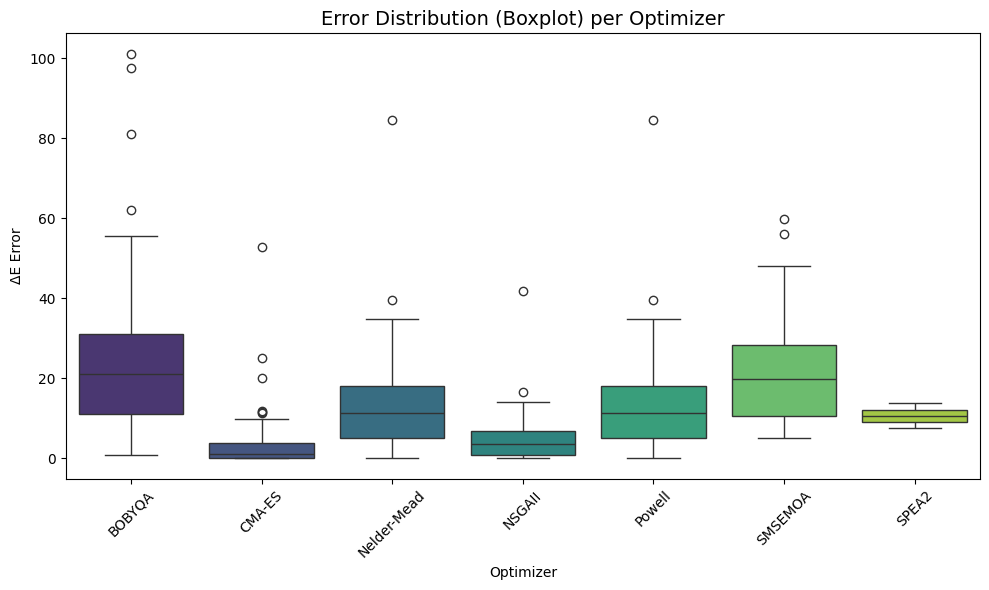

In [65]:
create_box_plot(db_folder)

# Parameter Influence

In [71]:
!! pip install scikit-learn

['Requirement already satisfied: scikit-learn in c:\\python310\\lib\\site-packages (1.7.2)',
 'Requirement already satisfied: threadpoolctl>=3.1.0 in c:\\python310\\lib\\site-packages (from scikit-learn) (3.6.0)',
 'Requirement already satisfied: scipy>=1.8.0 in c:\\python310\\lib\\site-packages (from scikit-learn) (1.15.3)',
 'Requirement already satisfied: joblib>=1.2.0 in c:\\python310\\lib\\site-packages (from scikit-learn) (1.5.2)',
 'Requirement already satisfied: numpy>=1.22.0 in c:\\python310\\lib\\site-packages (from scikit-learn) (2.2.6)',
 'WARNING: You are using pip version 21.2.3; however, version 25.3 is available.',
 "You should consider upgrading via the 'C:\\Python310\\python.exe -m pip install --upgrade pip' command."]

In [ ]:
cmaes_db_folder = "C:\\Users\\safii\\CI_presentation\\datasets\\hyperparam_runs\\cmaes\\"

all_rows = [] 
for file in os.listdir(cmaes_db_folder):
    target = ""
    dataset = pd.read_csv(cmaes_db_folder + file)
    dataset["resultWeights"] = dataset["resultWeights"].str.split(";").apply(lambda x: list(map(float, x)))
    dataset["targetWeights"] = dataset["targetWeights"].str.split(";").apply(lambda x: list(map(float, x)))

    # --- Compute domain-aware or simple weight errors ---
    dataset["NumFalseWeights"] = dataset.apply(
        lambda row: count_false_weights(
            row["resultWeights"], row["targetWeights"], 0.1, SIMILAR_GROUPS
        ),
        axis=1
    )

    dataset["RMSEFalseWeights"] = dataset.apply(
        lambda row: rmse_false_weights(
            row["resultWeights"], row["targetWeights"], 0.1, SIMILAR_GROUPS
        ),
        axis=1
    )

    dataset["Error"] = dataset.apply(
        lambda row: deltaE76(
            row["resultWeights"], row["targetWeights"]
        ),
        axis=1
    )

    summary = {
        "file": file,
        "mean_error": dataset["Error"].mean(),
        "median_error": dataset["Error"].median(),
        "max_error": dataset["Error"].max(),
        "rmse_false_mean": dataset["RMSEFalseWeights"].mean(),
        "num_false_mean": dataset["NumFalseWeights"].mean(),
    }

    hyperparams = [
        "populationMultiplier",
        "sigma",
        "diagonalOnly",
        "checkFeasibleCount",
        "stopFitness"
    ]
    hp_values = {hp: dataset[hp].iloc[0] for hp in hyperparams if hp in dataset.columns}

    # 4. Add file name and hyperparameters per row
    for _, row in dataset.iterrows():
        entry = {
            "Error": row["Error"],
            "NumFalse": row["NumFalseWeights"],
            "RMSEFalse": row["RMSEFalseWeights"],
        }
        entry.update(hp_values)  # add hyperparameters to row

        all_rows.append(entry)

all_data = pd.DataFrame(all_rows)

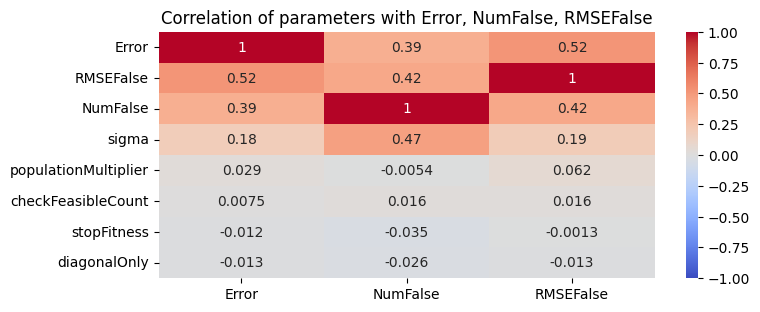

In [89]:
targets = ["Error", "NumFalse", "RMSEFalse"]

numeric = all_data.select_dtypes(include=[np.number])

corr_subset = numeric.corr()[targets]
corr_subset = corr_subset.sort_values(by="Error", ascending=False)

plt.figure(figsize=(8, len(corr_subset) * 0.4))
sns.heatmap(
    corr_subset,
    cmap="coolwarm",
    annot=True,
    vmin=-1, vmax=1
)
plt.title("Correlation of parameters with Error, NumFalse, RMSEFalse")
plt.show()
